# Project B - Style Transfer

This file contains two parts. The first part is our implementation of Gatys paper on Style Transfer. The second part is the test part of Image-to-Image Translation using Cycle-GANs.

## Author

Qingyuan jin, Junliang Yu, Sixuan Feng, Liu Liu

## Part 1 - Neural Style Transfer

### Discription

This is our implementation of Neural Style Transfer. We implement it based on Gatys paper on Style Transfer and official tutorial in PyTorch documents. 

### Prerequisites

- Python 3.3 or above
- Pytorch 0.4.0
- Torchvision

For UCSD `DSMLP` user, you can type following commands:
```bash
pip install torchvision
```

### Code

In [11]:
import numpy as np 
import torch
from torch import nn
from torch.nn import functional as F 
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import torchvision as tv

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 

In [13]:
def getimage(image_path,image_size=(512,512)):
    transform = tv.transforms.Compose([
            tv.transforms.Resize(image_size),
            tv.transforms.ToTensor(),
            ])
    img = Image.open(image_path).convert('RGB')
    img = transform(img)
    img = img[None,:,:,:]
    return img.to(device, torch.float)

In [14]:
def myimshow(image, title,save=False,ax=plt):
    fig=plt.figure()  
    image = image.squeeze(0) 
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1]) 
    h = ax.imshow(image) 
    ax.title(title)
    ax.axis('off') 
    
    if save:
        fig.savefig('{}.jpg'.format(title))
    return h

In [15]:
class NormalizeModule(nn.Module):
    def __init__(self):
        super(NormalizeModule, self).__init__()
        self.mean = torch.tensor([0.5, 0.5, 0.5]).view(-1, 1, 1).to(device)
        self.std = torch.tensor([0.5, 0.5, 0.5]).view(-1, 1, 1).to(device)

    def forward(self, x):
        f = (x - self.mean) / self.std
        return f

In [16]:
class ClossModule(nn.Module):

    def __init__(self, f_content,):
        super(ClossModule, self).__init__()
        self.f_content = f_content.detach()

    def forward(self, x):
        self.loss = F.mse_loss(x, self.f_content)/2
        return x

In [17]:
class SlossModule(nn.Module):

    def __init__(self, f_style):
        super(SlossModule, self).__init__()
        self.G_style = gram_matrix(f_style).detach()

    def forward(self, x):
        G_input = gram_matrix(x)
        self.loss = F.mse_loss(G_input, self.G_style)
        return x

In [18]:
def gram_matrix(x):
        B, N, W, H = x.size()  
        f = x.view(B*N, W*H)  
        G = torch.mm(f, f.t())/(2*B*N*W*H)  
        return G

def getmodel(style_img, content_img,content_layers,style_layers):
    
    vgg = tv.models.vgg19(pretrained=True).features.to(device)
    
    model = nn.Sequential()
    model.add_module('Normalization', NormalizeModule().to(device))

    i = 0  
    j = 0
    m = 0
    n = 0
    for layer in vgg:
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'Conv_{}'.format(i)
        else:
            if isinstance(layer, nn.ReLU):
                layer = nn.ReLU(inplace=False)
            j += 1
            name = 'Notconv_{}'.format(j)

        model.add_module(name, layer)

        if name[5:] in str(content_layers):
            m += 1
            f_content = model(content_img).detach()
            Closs = ClossModule(f_content)
            model.add_module("Closs_{}".format(m), Closs)
          

        if name[5:] in str(style_layers):
            n += 1
            f_style = model(style_img).detach()
            Sloss = SlossModule(f_style)
            model.add_module("Sloss_{}".format(n), Sloss)
            
        if m==len(content_layers) and n==len(style_layers):
            break
    return model

In [19]:
def nst(input_img,content_img, style_img,
                       content_layers,style_layers,
                       style_weight=1000000, content_weight=1,tol=np.inf,T=3000,lr=0.001):
    
    model = getmodel(style_img, content_img,content_layers,style_layers)
    optimizer = torch.optim.Adam([input_img.requires_grad_()],lr=lr)
    
    epoch=0
    running_loss=np.inf
    while epoch<T or running_loss>tol:
        optimizer.zero_grad()
        model(input_img)
        style_loss = 0
        content_loss = 0

        for name, module in model.named_children():
            if 'Sloss' in name:
                style_loss += module.loss
            if 'Closs' in name:
                content_loss += module.loss

        loss = style_weight*style_loss + content_weight*content_loss
        loss.backward()

        optimizer.step()
        
        epoch += 1
        running_loss = loss.item()
        if epoch % 300 == 299:
            print("epoch : {}:".format(epoch+1))
            print('Weighted Loss : {}'.format(running_loss))

    input_img.data.clamp_(0, 1)
    return input_img


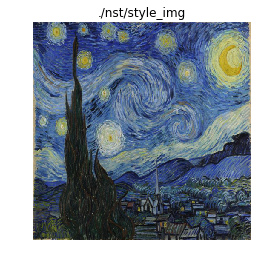

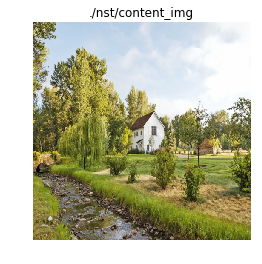

In [20]:
style_img = getimage('./nst/starry.jpg')
content_img = getimage('./nst/house.jpg')
myimshow(style_img,'./nst/style_img')
myimshow(content_img,'./nst/content_img')

In [21]:
content_layers_0 = [4]
style_layers_0 = [1,2,3,4]

In [22]:
input_img = content_img.clone()

output = nst(input_img,content_img, style_img,
             content_layers=content_layers_0,style_layers=style_layers_0,)

epoch : 300:
Weighted Loss : 18.179954528808594
epoch : 600:
Weighted Loss : 10.67117977142334
epoch : 900:
Weighted Loss : 7.74111795425415
epoch : 1200:
Weighted Loss : 6.080114364624023
epoch : 1500:
Weighted Loss : 5.01051139831543
epoch : 1800:
Weighted Loss : 4.227899551391602
epoch : 2100:
Weighted Loss : 3.6144652366638184
epoch : 2400:
Weighted Loss : 3.1223044395446777
epoch : 2700:
Weighted Loss : 2.729996681213379
epoch : 3000:
Weighted Loss : 2.420379877090454


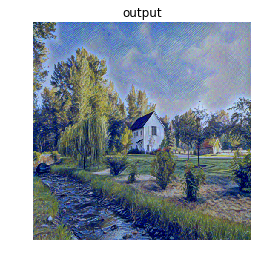

In [23]:
myimshow(output.detach(),'output',save=True)

## Part 2 - Image-to-Image Translation using Cycle-GANs

### Discription

In this part, we implement our version of Image-to-Image Translation using Cycle-GANs based on the given paper and Jun-Yan Zhu's guide on cycle_gan. We focus on transferring from landscape photographs to two main artistic styles, Pointillism and Baroque. For this demo, we use our trained model and several test data. The result will display in a .html file.

### Prerequisites

- Python 3.3 or above
- Pytorch 0.4.0
- Torchvision
- dominate 2.3.1

For UCSD `DSMLP` user, you can type following commands:
```bash
pip install dominate==2.3.1
pip install torchvision
```

### Code